# CBDC ABM Simulation

This notebook contains a simulation for a toy economy that consists of a number of households, firms, banks and a central bank. Households are employed at firms, are paid wages for labour, produce output and purchase output. Wages are paid and output is paid for using a combination of deposits at banks and Central Bank Digital Currency.

## Configuring the model

The parameter_values below can be specified for different simulations.

In [1]:
import xml.etree.ElementTree as ET

Below you will find the parameter inputs for this model. Change the parameter values for different configurations of the model.

In [2]:
parameter_values = (('num_sweeps', '121'),
                    ('num_simulations', '1'),
                    ('num_households', '40'),
                    ('num_firms', '8'),
                    ('num_banks', '2'),
                    ('num_ach', '1'),
                    ('num_central_bank', '1'),
                    ('batch', '2'),
                    ('reserves_interest', '0.00'),
                    ('loans_central_bank_interest', '0.000118'),
                    ('open_market_operations_interest', '0.000116'),
                    ('loans_interbank_interest', '0.000115'),
                    ('loans_interest', '0.0004'),
                    ('deposits_interest', '0.00008'),
                    ('clearing_house_fee', '0.01'),
                    ('household_directory', 'agents/gen_households/'),
                    ('firm_directory', 'agents/gen_firms/'),
                    ('bank_directory', 'agents/gen_banks/'),
                    ('ach_directory', 'agents/ach/'),
                    ('central_bank_directory', 'agents/central_bank/'),
                    ('measurement_config', 'measurements/test_output.xml')
                   )

To translate this to an xml document, which the framework can read, we first need create an ET element. 

In [3]:
environment = ET.Element('environment', identifier = "CBDC_parameters")

And create parameter elements and give them the values seen below to add to the tree object.

In [4]:
parameters = []
for x in range(len(parameter_values)):
    parameters.append(ET.SubElement(environment, 'parameter'))
    
for idx, p in enumerate(parameters):
    p.set('type', 'static')
    p.set('name', parameter_values[idx][0])
    p.set('value', parameter_values[idx][1])

This object can now be transformed to a string and written to an xml file using the code below. 

In [5]:
xml_params = ET.tostring(environment, encoding="UTF-8")
myfile = open("environments/CBDC_parameters.xml", "w")
xml_params = "<?xml version='1.0' encoding='UTF-8'?>\n" + str(xml_params, encoding = "UTF-8")
myfile.write(xml_params)
myfile.close()

Now, the parameter xml file has been generated and the model can be run. Before, running the model, you need to import a couple of extra modules. These are the Python logging module, the Black Rhino environment class, and the Black Rhino runner class.

In [6]:
import logging
import os
from src.environment import Environment
from src.runner import Runner

Then, before running the model, the logger needs to be initialized.

In [7]:
log_directory = "log/"
identifier = "/CBDC_parameters"
environment_directory = "environments/"
if not os.path.exists('log'):
    os.makedirs('log')
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    filename=log_directory + identifier + ".log", level=logging.INFO)
logging.info('START logging for run: %s',  environment_directory + identifier + ".xml")

Generate banks and households using the generate agents class. First remove any agents still in directories. Then generate agents, the number of households and banks needs to be specified. In the generate banks method, the number of banks is the second argument. In the generate households method, the number of households it the second argument and the number of banks is the thrid argument.

In [8]:
import os
remove = True

bank_dir = os.getcwd()+'/agents/gen_banks/'
house_dir = os.getcwd()+'/agents/gen_households/'
firm_dir = os.getcwd()+'/agents/gen_firms/'
if remove:
    bank_list = [ f for f in os.listdir(bank_dir) if f.startswith("bank") ]
    house_list = [ f for f in os.listdir(house_dir) if f.startswith("house") ]
    firm_list = [ f for f in os.listdir(firm_dir) if f.startswith("firm") ]
for f in bank_list:
    os.remove(os.path.join(bank_dir, f))
for f in house_list:
    os.remove(os.path.join(house_dir, f))
for f in firm_list:
    os.remove(os.path.join(firm_dir, f))

In [9]:
from src.br_generate_agents import Generate_Agents
gen_agents = Generate_Agents()

gen_agents.generate_households(parameter_values[2][1], "./agents/gen_households/")

gen_agents.generate_firms(parameter_values[3][1], "./agents/gen_firms/")

gen_agents.generate_banks(parameter_values[4][1], "./agents/gen_banks/")

First, the environment will be initialized. It contains the model parameters and variables. The environment also contains a list of agents. In the Solow model, the environment contains one bank, one firm, and one household. Finally, it also contains initialized transactions for these agents.

In [10]:
environment = Environment(environment_directory, identifier)


Import GDP data for calibration. Data is average GDP per firm per employee over 4000 (The mean of the labour distribution).

In [11]:
# # importing the module
# import json
  
# # Opening JSON file
# with open('gdp.json') as json_file:
#     gdp_calibrate = json.load(json_file)
# environment.gdp_calibrate = gdp_calibrate

Next up, the runner object is created. As the name suggests, the runner object handles the running of the model. But that is not all, it also initializes the updater.

In [12]:
runner = Runner(environment)

Now you can actually run the model. Since the agent-based model is simulated using Monte Carlo methods. This means that the model will be run multiple times (num_simulations). For every simulation run, the environment and runner will be (re-)initialized. Then, the runner will run the Solow model. During the run, the runner will write data about capital to a csv file specified within the Measurement class and print out all the transactions happening and the books of firm and household at the end of each sweep.

In [13]:
for i in range(int(environment.num_simulations)):
    logging.info('  STARTED with run %s',  str(i))
    environment.initialize(environment_directory,  identifier)
    runner.initialize(environment)
    
    runner.do_run(environment)
    logging.info('  DONE')

measurements/test_output.xml

 central_bank initialize with 17633.0 reserves

 central_bank initialize with 21463.0 reserves

 RTGS payment of 3223.0 of reserves from bank_1 to central_bank at time 0d.
firm_5 took out loan of 3223.0 for capital

 RTGS payment of 1217.0 of reserves from bank_1 to central_bank at time 0d.
firm_4 took out loan of 1217.0 for capital

 RTGS payment of 2871.0 of reserves from bank_0 to central_bank at time 0d.
firm_6 took out loan of 2871.0 for capital

 RTGS payment of 3262.0 of reserves from bank_1 to central_bank at time 0d.
firm_7 took out loan of 3262.0 for capital

 RTGS payment of 2435.0 of reserves from bank_1 to central_bank at time 0d.
firm_3 took out loan of 2435.0 for capital

 RTGS payment of 2652.0 of reserves from bank_1 to central_bank at time 0d.
firm_2 took out loan of 2652.0 for capital

 RTGS payment of 895.0 of reserves from bank_0 to central_bank at time 0d.
firm_0 took out loan of 895.0 for capital

 RTGS payment of 2334.0 of reserves 

In [14]:
environment.number_of_deposits

5412

Check to see if all agents balance sheets are consistent. Rounding erros may result in not all agents having consistent balance sheets.

In [15]:
npv = 0.0
wealth = 0.0
for houses in environment.households:
    npv += houses.check_npv()[houses.identifier]["npv"]
    wealth += houses.wealth

print(f"Household NPV is {round(npv, 2)} and wealth is {wealth}")

firm = True
for firms in environment.firms:
    firm *= firms.check_consistency()
if firm:
    print("All firms have consistent balance sheets")
else:
    print("Not all firms have consistent balance sheets")

bank = True
for banks in environment.banks:
    bank *= banks.check_consistency()
if bank:
    print("All banks have consistent balance sheets")
else:
    print("Not all banks have consistent balance sheets")

if environment.ach[0].check_consistency():
    print("ACH has consistent balance sheets")
elif environment.ach[0].check_consistency() is False:
    print("ACH does not consistent balance sheets")

print(f"Central Bank reserves are {environment.central_bank[0].get_account('reserves')}")

# if environment.central_bank[0].check_consistency():
#     print("Central Bank has consistent balance sheets")
# elif environment.central_bank[0].check_consistency() is False:
#     print("Central Bank does not consistent balance sheets")

Household NPV is 39095.9 and wealth is 39096.0
All firms have consistent balance sheets
All banks have consistent balance sheets
ACH has consistent balance sheets
Central Bank reserves are 430.90736364123836


Print Balance Sheet for one randomly selected household, firm and bank, and central bank.

In [16]:
import pandas as pd
from functools import reduce

balance_b = []
for agent in environment.banks:
    balance_sheet = agent.balance_sheet()
    agent_bal = pd.DataFrame.from_dict(balance_sheet[agent.identifier], orient="columns")
    agent_bal.rename({"ach_payee_" + agent.identifier : "ach_payee", "ach_payer_" + agent.identifier : "ach_payer"}, inplace=True)
    agent_bal.rename({"loans_interbank_" + agent.identifier : "loans_interbank"}, inplace=True)
    agent_bal.loc['Total'] = round(agent_bal.sum(), 0)
    balance_b.append(agent_bal)

print("Total Bank Balance Sheet")
bank_balance = round(reduce(lambda x, y: x.add(y, fill_value=0), balance_b), 6)
print(bank_balance)

balance_sheet_ach = environment.ach[0].balance_sheet()
ach_bal = pd.DataFrame.from_dict(balance_sheet_ach["ach"], orient="columns")
ach_bal.loc['Total']= round(ach_bal.sum(), 0)
print("ACH Balance Sheet")
print(ach_bal)

balance_f = []
for agent in environment.firms:
    balance_sheet = agent.balance_sheet()
    agent_bal = pd.DataFrame.from_dict(balance_sheet[agent.identifier], orient="columns")
    agent_bal.loc['Total']= round(agent_bal.sum(), 0)
    balance_f.append(agent_bal)

print("Total Firm Balance Sheet")
firm_balance = reduce(lambda x, y: x.add(y, fill_value=0), balance_f)
print(firm_balance)

balance_h = []
for agent in environment.households:
    balance_sheet = agent.balance_sheet()
    agent_bal = pd.DataFrame.from_dict(balance_sheet[agent.identifier], orient="columns")
    agent_bal.loc['Total']= round(agent_bal.sum(), 0)
    balance_h.append(agent_bal)

print("Total Household Balance Sheet")
house_balance = reduce(lambda x, y: x.add(y, fill_value=0), balance_h)
print(house_balance)



balance_sheet_cb = environment.central_bank[0].balance_sheet()
central_bank_bal = pd.DataFrame.from_dict(balance_sheet_cb["central_bank"], orient="columns")
central_bank_bal.loc['Total']= round(central_bank_bal.sum(), 0)
print("Central Bank Balance Sheet")
print(central_bank_bal)

total_balance = central_bank_bal[-1:] + bank_balance[-1:] + firm_balance[-1:] + house_balance[-1:] 
print("Overall Balance Sheet Totals")
print(total_balance)

Total Bank Balance Sheet
                              assets   liabilities
interbank_loans           187.384801           NaN
loans                   19150.156810           NaN
reserves                  408.963136           NaN
bank_notes                  0.000000           NaN
open_market_operations  19798.237504           NaN
clearing_house_fee         21.944227           NaN
ach_payee                   0.000000           NaN
deposits                         NaN  20448.156810
receivables                      NaN      0.000000
loans_central_bank               NaN     22.144868
ach_payer                        NaN      0.000000
loans_interbank                  NaN    187.384801
equity                           NaN  18909.000000
Total                   39566.000000  39566.000000
ACH Balance Sheet
                       assets  liabilities
ach_payer            0.000000          NaN
reserves            21.944227          NaN
ach_payee                 NaN     0.000000
clearing_house_fee  

In [17]:
import pandas as pd
thesis_data = pd.read_csv('measurements/TestMeasurement.csv', index_col=0) 

In [18]:
print(thesis_data.head(3))
print(thesis_data.tail(4))

      Total Deposit Payments  Deposit Payments  Total Output  Bank 0 Deposits  \
Step                                                                            
1                   0.000000          0.000000           0.0      6843.000000   
2                  40.000000         40.000000          40.0      6827.590948   
3                  80.000002         40.000002          80.0      6817.927425   

      Bank 1 Deposits  Bank 2 Deposits  Bank 3 Deposits  Total Deposits  \
Step                                                                      
1        13344.000000              NaN              NaN    20187.000000   
2        13342.632064              NaN              NaN    20170.223012   
3        13369.072575              NaN              NaN    20187.000000   

      Total Loans  Total Receivables  ...    reserves  bank_notes  \
Step                                  ...                           
1         18889.0       0.000000e+00  ...  136.860000         0.0   
2         1

In [19]:
print(thesis_data)

      Total Deposit Payments  Deposit Payments  Total Output  Bank 0 Deposits  \
Step                                                                            
1                   0.000000          0.000000           0.0      6843.000000   
2                  40.000000         40.000000          40.0      6827.590948   
3                  80.000002         40.000002          80.0      6817.927425   
4                 120.000003         40.000001         120.0      6802.610584   
5                 160.000002         39.999999         160.0      6797.770390   
...                      ...               ...           ...              ...   
117              9080.000030         39.999999        4640.0      7240.926894   
118              9120.000030         40.000000        4680.0      7236.215668   
119              9160.000031         40.000001        4720.0      7233.316543   
120              9200.000032         40.000001        4760.0      7222.591168   
121              9240.000034

In [20]:
import matplotlib.pyplot as plt

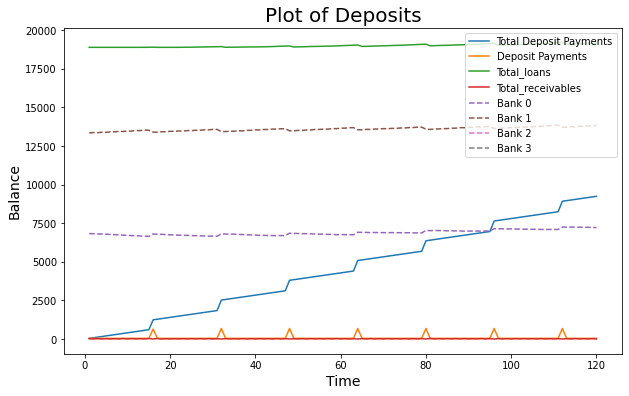

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
thesis_data.index = range(len(thesis_data))
thesis_data_plot = thesis_data[['Total Deposit Payments', 'Deposit Payments', 'Bank 0 Deposits', "Bank 1 Deposits", "Bank 2 Deposits", "Bank 3 Deposits", "Total Loans", "Total Receivables"]].drop([0])#, 'Open Market Operations']].drop([0])#.drop(["Total Output", "Bank 0 Reserves", "Bank 1 Reserves", "Bank 2 Reserves", "Bank 3 Reserves", 'Bank 0 Interbank Loans', 'Bank 1 Interbank Loans', 'Bank 2 Interbank Loans', 'Bank 3 Interbank Loans', "interbank_loans", "loans", "reserves", "bank_notes", "open_market_operations_0","ach_payee_bank_0"], 1)
ax.plot(thesis_data_plot.index, thesis_data_plot[['Total Deposit Payments', 'Deposit Payments', "Total Loans", "Total Receivables"]])
ax.plot(thesis_data_plot.index, thesis_data_plot[['Bank 0 Deposits', "Bank 1 Deposits", "Bank 2 Deposits", "Bank 3 Deposits"]], "--")
ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['Total Deposit Payments', 'Deposit Payments', "Total_loans", "Total_receivables", "Bank 0 ", "Bank 1", "Bank 2", "Bank 3"])
plt.title("Plot of Deposits", size=20)

fig.savefig('figures/Deposit_Payments.png')

/var/folders/nx/sfr0g06x255301jlc_nyn7c00000gn/T/ipykernel_11307/4165880962.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  thesis_data_plot = thesis_data.drop(['Total Output','Total Deposit Payments', 'Deposit Payments', 'Total Deposits', 'Total Loans', 'Total Receivables', 'Bank 0 Deposits', 'Bank 1 Deposits', 'Bank 2 Deposits', 'Bank 3 Deposits', "interbank_loans", "loans", "reserves", "bank_notes", "open_market_operations_0","ach_payee_bank_0"], 1)


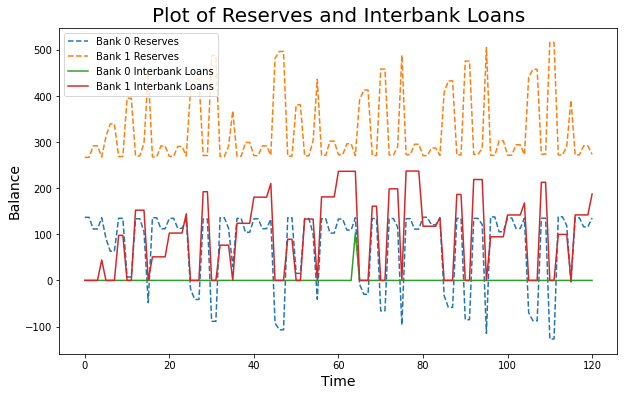

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
thesis_data.index = range(len(thesis_data))
thesis_data_plot = thesis_data.drop(['Total Output','Total Deposit Payments', 'Deposit Payments', 'Total Deposits', 'Total Loans', 'Total Receivables', 'Bank 0 Deposits', 'Bank 1 Deposits', 'Bank 2 Deposits', 'Bank 3 Deposits', "interbank_loans", "loans", "reserves", "bank_notes", "open_market_operations_0","ach_payee_bank_0"], 1)
#thesis_data_plot = thesis_data_plot.transform(lambda CBDC_Payments: CBDC_Payments * gdp_calibrate[0]["Num_Firms"]/800 + gdp_calibrate[0]["GDP"])
ax.plot(thesis_data_plot.index, thesis_data_plot[["Bank 0 Reserves", "Bank 1 Reserves"]], "--")#, "Bank 2 Reserves", "Bank 3 Reserves", "Bank 4 Reserves", "Bank 5 Reserves", "Bank 6 Reserves", "Bank 7 Reserves", "Bank 8 Reserves", "Bank 9 Reserves"]], "--")
ax.plot(thesis_data_plot.index, thesis_data_plot[['Bank 0 Interbank Loans', 'Bank 1 Interbank Loans']])#, 'Bank 2 Interbank Loans', 'Bank 3 Interbank Loans', "Bank 4 Interbank Loans", "Bank 5 Interbank Loans", "Bank 6 Interbank Loans", "Bank 7 Interbank Loans", "Bank 8 Interbank Loans", "Bank 9 Interbank Loans"]])
ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(["Bank 0 Reserves", "Bank 1 Reserves",'Bank 0 Interbank Loans', 'Bank 1 Interbank Loans'])# "Bank 2 Reserves", "Bank 3 Reserves", "Bank 4 Reserves", "Bank 5 Reserves", "Bank 6 Reserves", "Bank 7 Reserves", "Bank 8 Reserves", "Bank 9 Reserves", 'Bank 0 Interbank Loans', 'Bank 1 Interbank Loans', 'Bank 2 Interbank Loans', 'Bank 3 Interbank Loans', "Bank 4 Interbank Loans", "Bank 5 Interbank Loans", "Bank 6 Interbank Loans", "Bank 7 Interbank Loans", "Bank 8 Interbank Loans", "Bank 9 Interbank Loans"])
plt.title("Plot of Reserves and Interbank Loans", size=20)


fig.savefig('figures/Reserves_and_Loans.png')

ValueError: When stacked is True, each column must be either all positive or all negative. Column 'reserves' contains both positive and negative values

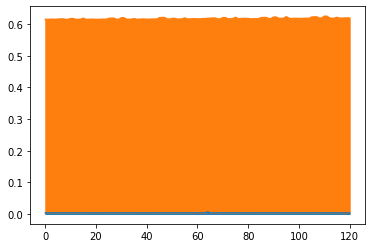

In [23]:
thesis_data_plot= thesis_data[["interbank_loans", "loans", "reserves", "bank_notes", "open_market_operations_0","ach_payee_bank_0"]]+100
thesis_data_plot.divide(thesis_data_plot.sum(1), 0).plot.area()

<AxesSubplot:>

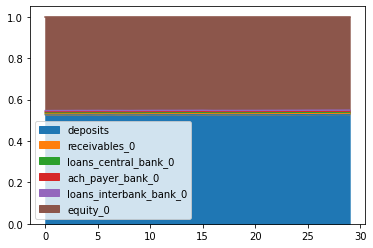

In [ ]:
thesis_data_plot= thesis_data[["deposits","receivables_0","loans_central_bank_0","ach_payer_bank_0","loans_interbank_bank_0","equity_0"]]+100
thesis_data_plot.divide(thesis_data_plot.sum(1), 0).plot.area()

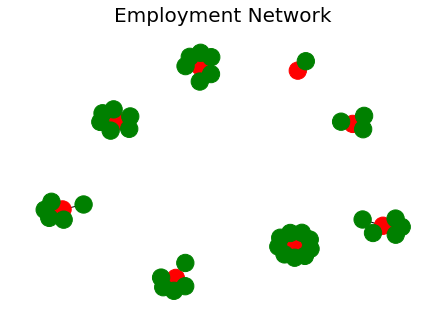

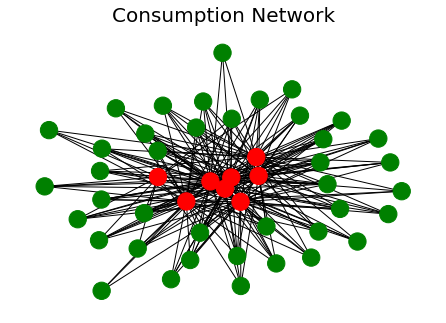

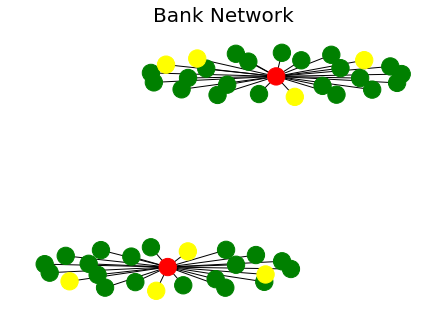

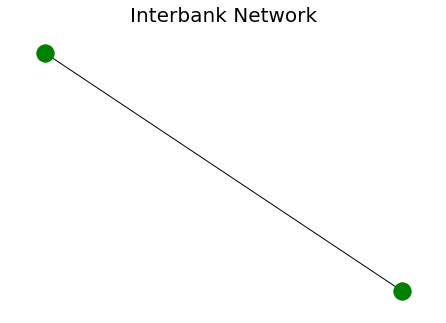

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
# Plot employment network    
E = environment.employment_network
color_map_E = ['red' if "firm" in node else 'green' for node in E]        
nx.draw(E, node_color=color_map_E)
plt.title("Employment Network", size=20)
plt.savefig('figures/employment_network.png')
plt.show()
# Plot consumption network
C = environment.consumption_network
color_map_C = ['red' if "firm" in node else 'green' for node in C]        
nx.draw(C, node_color=color_map_C)
plt.title("Consumption Network", size=20)
plt.savefig('figures/consumption_network.png')
plt.show()
# Plot bank network
B = environment.bank_network
color_map_B = ['red' if "bank" in node else 'yellow' if "firm" in node else 'green' for node in B]        
nx.draw(B, node_color=color_map_B)
plt.title("Bank Network", size=20)
plt.savefig('figures/bank_network.png')
plt.show()
# Plot interbank network
I = environment.interbank_network    
nx.draw(I, node_color="g")
plt.title("Interbank Network", size=20)
plt.savefig('figures/interbank_network.png')
plt.show()


In [ ]:
# hh = environment.households[0]
# hh_bank_acc = environment.bank_network.adj[hh.identifier]
# firm = environment.firms[0]
# firm_bank_acc = environment.bank_network.adj[firm.identifier]
# time = 1
# k = 100
# print(hh.identifier)
# print(firm.identifier)
# consumption_demand = {"type_": "deposit", "from_" : hh.identifier, "to" : firm.identifier, "amount" : k, "bank_from":hh_bank_acc, "bank_to":firm_bank_acc, "time" : time}
# environment.new_transaction(type_="deposits", asset='', from_= consumption_demand["from_"], to = consumption_demand["to"], amount = consumption_demand["amount"], interest=0.05, maturity=0, time_of_default=-1)